Обучить сиамскую сеть для верификации лиц на датасете LFW
Библиотеки: [Python, Tensorflow]

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import tensorflow_datasets as tfds
import tensorflow as tf
import codecs
from collections import Counter
import os
import time

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
def time_matmul(x):
  start = time.time()
  for loop in range(100):
    tf.matmul(x, x)

  result = time.time()-start

  print("100 циклов: {:0.2f}ms".format(1000*result))

for i in range(2):
    # исполнение CPU
    print(" CPU работает:")
    with tf.device("CPU:0"):
      x = tf.random.uniform([1000, 1000])
      assert x.device.endswith("CPU:0")
      time_matmul(x)

    # исполнение на GPU #0 , если доступен
    if tf.config.experimental.list_physical_devices("GPU"):
      print("GPU работает:")
      with tf.device("GPU:0"): # или GPU:1 , для 2х GPU, GPU:2 для 3х  и т.д.
        x = tf.random.uniform([1000, 1000])
        assert x.device.endswith("GPU:0")
        time_matmul(x)

 CPU работает:
100 циклов: 354.32ms
GPU работает:
100 циклов: 307.28ms
 CPU работает:
100 циклов: 328.30ms
GPU работает:
100 циклов: 6.01ms


## Загрузим данные

In [65]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)


Получим, трейн, тест и имена в numpy

In [66]:
ds_im = []
ds_l = []
for i in train_ds:
    ds_im.append(i[1].numpy())
    ds_l.append(codecs.decode(i[0].numpy(), 'UTF-8'))
ds_im = np.array(ds_im)
ds_im = ds_im/255
names_tr = list(set(ds_l))
len(ds_l),len(names_tr)

(11910, 5326)

для теста

In [67]:
val_im = []
val_l = []
for i in test_ds:
    val_im.append(i[1].numpy())
    val_l.append(codecs.decode(i[0].numpy(), 'UTF-8'))
# val_im = np.array(val_im,np.float32)
val_im =np.array( val_im)
val_im = val_im / 255
names_val = list(set(val_l))
len(val_l),len(names_val)
    

(1323, 962)

In [68]:
names = list(set(names_tr + names_val))

ds_lab_enc=[]
for i in ds_l:
    ds_lab_enc.append(names.index(i))
ds_lab_enc = np.array(ds_lab_enc) 

val_lab_enc = []
for i in val_l:
    val_lab_enc.append(names.index(i))
val_lab_enc = np.array(val_lab_enc)


In [69]:
# Длинна трейна и теста
len(train_ds),len(test_ds),len(ds_lab_enc),len(val_lab_enc),len(names)

(11910, 1323, 11910, 1323, 5749)

Barry_Ford ,индекс - 1189


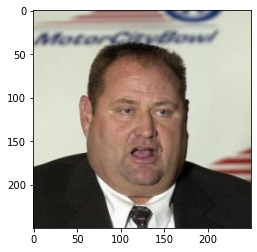

In [70]:
# Посмотрим картинку
plt.imshow(ds_im[0])
print(names_tr[0], ',индекс -', ds_lab_enc[0])

как видно первым идет label, вторым image

## Построение сети

In [71]:
EMB_SIZE = 128
inp = tf.keras.layers.Input(shape=(250,250,3))
x = tf.keras.layers.Conv2D(32, (6, 6), padding='same', activation='relu')(inp) #250

x = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(x) #125

x = tf.keras.layers.Conv2D(64, (4, 4), padding='valid', activation='relu')(x) # 122

x = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(x) #61


x = tf.keras.layers.Conv2D(128, (4, 4), padding='valid', activation='relu')(x) # 58

x = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(x) # 29

x = tf.keras.layers.Conv2D(256, (4, 4), padding='valid', activation='relu')(x) # 26

x = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(x) # 13

x = tf.keras.layers.Conv2D(512, (2, 2), padding='valid', activation='relu')(x) #12

x = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(x) #6

x =  tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x =  tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x =  tf.keras.layers.Dropout(0.2)(x)
out = tf.keras.layers.Dense(EMB_SIZE, activation=None)(x)


model = tf.keras.Model(inp,out)
model.summary()
                            

    

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 250, 250, 32)      3488      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 122, 122, 64)      32832     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 58, 58, 128)       131200    
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 29, 29, 128)       0   

## Contrastive Loss

In [72]:
MARGIN = 50.0

def contastive_loss(embs, labels):    
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [73]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

### Формирование бача для обучения

In [74]:
def make_bath(image,label,ds,lab):
    rand_ind = np.random.choice(np.arange(len(ds)))
    rand_ind2 = np.random.choice(np.arange(len(ds)))
    rand_ind3 = np.random.choice(np.arange(len(ds)))
    rand_lab = lab[rand_ind]
    rand_lab2= lab[rand_ind2]
    rand_lab3= lab[rand_ind3]
    rand_im = ds[rand_ind]
    rand_im2 = ds[rand_ind2]
    rand_im3 = ds[rand_ind3]
    
    same_im_ind = np.where(lab==label)[0]
    if len(same_im_ind)>0:
        same_im_ind1 = np.random.choice(same_im_ind)
        same_im = ds[same_im_ind1]
        same_lab = lab[same_im_ind1]
        same_im_ind2 = np.random.choice(same_im_ind)
        same_im2 = ds[same_im_ind2]
        same_lab2 = lab[same_im_ind2]
        
    else:
        same_im = image
        same_lab = label
    image = image.reshape((-1,)+image.shape)  
    label = np.array([label])
    rand_im = rand_im.reshape(image.shape) 
    rand_lab = np.array([rand_lab]) 
    rand_im2 = rand_im2.reshape(image.shape) 
    rand_lab2 = np.array([rand_lab2]) 
    rand_im3 = rand_im3.reshape(image.shape) 
    rand_lab3 = np.array([rand_lab3]) 

    same_im = same_im.reshape(image.shape)
    same_im2 = same_im.reshape(image.shape)
    same_lab = np.array([same_lab]) 
    same_lab2 = np.array([same_lab2]) 
    im = np.concatenate((image,   image,     same_im, same_im, same_im2,  same_im2, \
                         same_im, same_im2,  image,   rand_im,  rand_im2, rand_im3),axis = 0)
    lab = np.concatenate((label,  label,  label,  label,    label,    label,\
                          label,  label,  label,  rand_lab, rand_lab2,rand_lab3))
    
    return   tf.convert_to_tensor(im),tf.convert_to_tensor(lab) 
        

### Обечение модели

In [77]:
%%time
for _ in range(1):
    loss = 0
    for iteration, (image,label) in enumerate(zip(ds_im,ds_lab_enc)): 
        im,lab = make_bath(image,label,ds_im,ds_lab_enc) 

        # Forward
        with tf.GradientTape() as tape:
            embs = model(im)
            loss_value = contastive_loss(embs, lab)
        # Backward
        grads = tape.gradient(loss_value, model.variables )
        optimizer.apply_gradients(zip(grads, model.variables))    
        if iteration % 500 == 0:
            val_loss_value = 0
            print(f' итерация - {iteration}, Train Loss: {loss_value.numpy()}')
            

 итерация - 0, Train Loss: 391.7834167480469
 итерация - 500, Train Loss: 258.2339172363281
 итерация - 1000, Train Loss: 1149.8428955078125
 итерация - 1500, Train Loss: 159.15841674804688
 итерация - 2000, Train Loss: 214.1015625
 итерация - 2500, Train Loss: 136.22386169433594
 итерация - 3000, Train Loss: 448.74755859375
 итерация - 3500, Train Loss: 1134.0787353515625
 итерация - 4000, Train Loss: 460.3902587890625
 итерация - 4500, Train Loss: 1324.5318603515625
 итерация - 5000, Train Loss: 708.5223999023438
 итерация - 5500, Train Loss: 229.965087890625
 итерация - 6000, Train Loss: 228.38002014160156
 итерация - 6500, Train Loss: 743.2461547851562
 итерация - 7000, Train Loss: 377.9139099121094
 итерация - 7500, Train Loss: 200.60948181152344
 итерация - 8000, Train Loss: 825.6349487304688
 итерация - 8500, Train Loss: 690.9697265625
 итерация - 9000, Train Loss: 233.55845642089844
 итерация - 9500, Train Loss: 43.40370559692383
 итерация - 10000, Train Loss: 364.9378967285156

In [78]:
# На валидации
for iteration_val, (images_val, labels_val) in enumerate(zip(val_im,val_lab_enc)):

    im_val,lab_val = make_bath(images_val,labels_val,val_im,val_lab_enc) 
    val_embs = model(im_val)
    val_loss_value  = val_loss_value + contastive_loss(val_embs, lab_val)      
val_loss_value = val_loss_value/iteration_val
print(f' Mean val Loss: {val_loss_value.numpy()}')

 Mean val Loss: 315.8950500488281


### Тестирование

In [79]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

In [86]:
faces_vectors = {}
for i,l in zip(val_im,names_val):
    res = model(i.reshape((-1,250,250,3)))
    faces_vectors[l] = (res,l)


In [96]:
len(faces_vectors)

962

In [98]:
not_true = []
my_iter = 0
for i,l in zip(val_im,names_val):
    res = model(i.reshape((-1,250,250,3)))
    test_1 = False
    test_2 = False
    test_3 = False

    person = l
    a = diff(res,faces_vectors[person][0])
    if a<1:
        test_1 = True

    random_person1 = np.random.choice(names_val)
    if random_person1 != person:
        b1 = diff(res,faces_vectors[random_person1][0])
        if b1>5:
            test_2 = True
    else:
        a1 = diff(res,faces_vectors[random_person1][0])
        if a1<1:
            test_2 = True

    random_person2 = np.random.choice(names_val)   
    if random_person1 != person:
        b2 = diff(res,faces_vectors[random_person2][0])
        if b2>5:
            test_3 = True
    else:
        a2 = diff(res,faces_vectors[random_person1][0])
        if a1<1:
            test_3 = True    

    my_iter += 1
    if test_1 and test_2 and test_3:
        continue
    print(f'Тест номер {my_iter} не прошел, {test_1,test_2,test_3}, {person,random_person1,random_person2 }')
    not_true.append((my_iter,test_1,test_2,test_3,person,random_person1,random_person2 ,\
                     res,faces_vectors[person],faces_vectors[random_person1],faces_vectors[random_person2]))

        
print(f'Доля прошедших {(len(names_val) -len(not_true))/len(names_val)}')   

Тест номер 43 не прошел, (True, True, False), ('David_Nalbandian', 'Bob_Stoops', 'David_Nalbandian')
Тест номер 180 не прошел, (True, False, True), ('John_Reid', 'Paul_Burrell', 'Carmen_Electra')
Тест номер 211 не прошел, (True, True, False), ('Tom_Miller', 'Carlos_Moya', 'Tom_Miller')
Тест номер 275 не прошел, (True, True, False), ('Leslie_Wiser_Jr', 'John_Robbins', 'Leslie_Wiser_Jr')
Тест номер 764 не прошел, (True, True, False), ('Al_Sharpton', 'James_Kelly', 'Al_Sharpton')
Доля прошедших 0.9948024948024948
